In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats

# Define parameters for easy adjustment
IQR_FACTOR = 1.5

def load_data(file_path):
    """
    Load the dataset from a parquet file.
    """
    df = pd.read_parquet(file_path)
    return df

def remove_missing_target(df):
    """
    Remove rows where the target variable 'Ewltp (g/km)' is missing.
    """
    initial_count = len(df)
    df = df.dropna(subset=['Ewltp (g/km)'])
    dropped = initial_count - len(df)
    print(f"Removed {dropped} rows without the target variable.")
    return df

def exclude_electric_propulsion(df):
    """
    Exclude vehicles with any type of electric propulsion based on fuel type and fuel mode.
    Also exclude hydrogen-fueled vehicles to prevent their categories from being dummy encoded.
    """
    initial_count = len(df)
    
    # Define fuel types and modes indicating electric propulsion
    electric_fuel_types = ['PETROL/ELECTRIC', 'DIESEL/ELECTRIC', 'ELECTRIC']
    electric_fuel_modes = ['E', 'P', 'H']
    
    # Remove rows with electric fuel types
    df = df[~df['Ft'].isin(electric_fuel_types)]
    dropped_ft = initial_count - len(df)
    
    # Update initial count after removing electric fuel types
    initial_count = len(df)
    
    # Remove rows with electric fuel modes
    df = df[~df['Fm'].isin(electric_fuel_modes)]
    dropped_fm = initial_count - len(df)
    
    # Additionally, remove hydrogen-fueled vehicles
    hydrogen_fuel_type = 'HYDROGEN'  # Assuming 'HYDROGEN' is the exact category name
    df = df[~df['Ft'].isin([hydrogen_fuel_type])]
    dropped_hydrogen = (initial_count - dropped_ft - len(df))
    
    total_dropped = dropped_ft + dropped_fm + dropped_hydrogen
    print(f"Excluded {total_dropped} vehicles with electric propulsion and hydrogen fuel type.")
    
    # Ensure 'Ft' and 'Fm' are of categorical type
    df['Ft'] = df['Ft'].astype('category')
    df['Fm'] = df['Fm'].astype('category')
    
    # Remove the electric categories from the categories metadata
    df['Ft'].cat.remove_categories(electric_fuel_types + [hydrogen_fuel_type], inplace=True)
    df['Fm'].cat.remove_categories(electric_fuel_modes, inplace=True)
    
    # Remove any unused categories
    df['Ft'].cat.remove_unused_categories(inplace=True)
    df['Fm'].cat.remove_unused_categories(inplace=True)
    
    return df


def combine_mass_variables(df):
    """
    Use 'Mt' where present; if not, substitute with 'm (kg)'.
    """
    df['Mass (kg)'] = df['Mt'].combine_first(df['m (kg)'])
    df = df.drop(columns=['Mt', 'm (kg)'])
    return df

def drop_missing_values(df, variables):
    """
    Drop rows with missing values in the specified variables.
    """
    total_rows = len(df)
    for var in variables:
        missing = df[var].isnull().sum()
        if missing > 0:
            share_dropped = missing / total_rows
            print(f"Variable '{var}': Dropping {missing} rows ({share_dropped:.2%}) due to missing values.")
    df = df.dropna(subset=variables)
    return df

def remove_outliers(df, numerical_vars, factor=IQR_FACTOR):
    """
    Remove outliers from numerical variables using the IQR method.
    """
    for var in numerical_vars:
        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        initial_count = len(df)
        df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
        dropped = initial_count - len(df)
        share_dropped = dropped / initial_count
        if dropped > 0:
            print(f"Variable '{var}': Removed {dropped} outliers ({share_dropped:.2%}).")
    return df

def encode_categorical(df, categorical_vars):
    """
    Apply one-hot encoding to categorical variables and return the list of new columns created.
    """
    # Get the list of columns before encoding
    cols_before_encoding = set(df.columns)
    # Perform encoding
    df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)
    # Get the list of new columns generated by encoding
    new_columns = list(set(df.columns) - cols_before_encoding)
    return df, new_columns

def prepare_features(df, target_var, explanatory_vars):
    """
    Prepare the feature matrix X and target vector y.
    """
    # Keep only the explanatory and target variables
    df = df[explanatory_vars + [target_var]]
    
    # Separate features and target
    X = df.drop(columns=[target_var])
    y = df[target_var]
    
    # Ensure all features are numeric
    X = X.apply(pd.to_numeric, errors='coerce')
    y = y.astype(float)
    
    # Drop any rows with NaN values introduced during conversion
    combined = pd.concat([X, y], axis=1)
    combined = combined.dropna()
    
    X = combined.drop(columns=[target_var])
    y = combined[target_var]
    
    return X, y

def calculate_test_statistics(X, y, model):
    """
    Calculate test statistics for the significance of each coefficient.
    """
    # Add intercept term
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X.values))
    params = np.append(model.intercept_, model.coef_)

    predictions = model.predict(X)
    residuals = y - predictions
    residual_sum_of_squares = np.sum(residuals ** 2)
    degrees_of_freedom = X_with_intercept.shape[0] - X_with_intercept.shape[1]
    mse = residual_sum_of_squares / degrees_of_freedom

    # Calculate variance-covariance matrix
    var_b = mse * np.linalg.inv(X_with_intercept.T.dot(X_with_intercept))
    standard_errors = np.sqrt(np.diagonal(var_b))

    t_stats = params / standard_errors
    p_values = [2 * (1 - stats.t.cdf(np.abs(t), degrees_of_freedom)) for t in t_stats]

    return params, standard_errors, t_stats, p_values



In [2]:
def main():
    # Load data
    df = load_data('your_dataset.csv')
    
    # Data Preparation
    df = remove_missing_target(df)
    df = exclude_electric_propulsion(df)
    df = combine_mass_variables(df)
    
    # Select variables
    numerical_vars = ['Mass (kg)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)']
    categorical_vars = ['Ft', 'Fm']
    target_var = 'Ewltp (g/km)'
    
    # Drop missing values in numerical variables before outlier removal
    df = drop_missing_values(df, numerical_vars)
    df = remove_outliers(df, numerical_vars)
    
    # Drop missing values in categorical variables before encoding
    df = drop_missing_values(df, categorical_vars)
    
    # Encode categorical variables and get the list of new columns
    df, encoded_columns = encode_categorical(df, categorical_vars)
    
    # Update explanatory_vars to include encoded categorical variables
    explanatory_vars = numerical_vars + encoded_columns
    
    # Prepare features and target
    X, y = prepare_features(df, target_var, explanatory_vars)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate test statistics
    params, std_errors, t_stats, p_values = calculate_test_statistics(X_train, y_train, model)

    # Prepare results
    feature_names = ['Intercept'] + list(X_train.columns)
    results = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': params,
        'Std Error': std_errors,
        't-Statistic': t_stats,
        'p-Value': p_values
    })

    print("\nRegression Coefficients and Test Statistics:")
    print(results)

In [3]:
# Load data
df = load_data("..\\..\\data\\EU\\EU_all_current_shared_Mp_Mh_tvv2.parquet")

In [4]:
# Data Preparation
df = remove_missing_target(df)
df = exclude_electric_propulsion(df)
df = combine_mass_variables(df)

Removed 3565598 rows without the target variable.
Excluded 2722185 vehicles with electric propulsion and hydrogen fuel type.


C:\Users\onepl\AppData\Local\Temp\ipykernel_17504\3705567692.py:62: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Ft'].cat.remove_categories(electric_fuel_types + [hydrogen_fuel_type], inplace=True)
C:\Users\onepl\AppData\Local\Temp\ipykernel_17504\3705567692.py:63: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['Fm'].cat.remove_categories(electric_fuel_modes, inplace=True)
C:\Users\onepl\AppData\Local\Temp\ipykernel_17504\3705567692.py:66: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df['Ft'].cat.remove_unused_categories(inplace=True)
C:\Users\onepl\AppData\Local\T

In [5]:
# Select variables
numerical_vars = ['Mass (kg)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)']
categorical_vars = ['Ft', 'Fm']
target_var = 'Ewltp (g/km)'
    
# Drop missing values in numerical variables before outlier removal
df = drop_missing_values(df, numerical_vars)
df = remove_outliers(df, numerical_vars)
    
# Drop missing values in categorical variables before encoding
df = drop_missing_values(df, categorical_vars)
  
# Encode categorical variables and get the list of new columns
df, encoded_columns = encode_categorical(df, categorical_vars)
 
# Update explanatory_vars to include encoded categorical variables
explanatory_vars = numerical_vars + encoded_columns
    
# Prepare features and target
X, y = prepare_features(df, target_var, explanatory_vars)


Variable 'Mass (kg)': Dropping 162 rows (0.00%) due to missing values.
Variable 'W (mm)': Dropping 939835 rows (11.60%) due to missing values.
Variable 'At1 (mm)': Dropping 1132771 rows (13.98%) due to missing values.
Variable 'At2 (mm)': Dropping 1136242 rows (14.02%) due to missing values.
Variable 'ec (cm3)': Dropping 802 rows (0.01%) due to missing values.
Variable 'ep (KW)': Dropping 398819 rows (4.92%) due to missing values.
Variable 'Mass (kg)': Removed 270389 outliers (4.11%).
Variable 'W (mm)': Removed 164322 outliers (2.61%).
Variable 'At1 (mm)': Removed 170482 outliers (2.78%).
Variable 'At2 (mm)': Removed 24658 outliers (0.41%).
Variable 'ec (cm3)': Removed 314781 outliers (5.30%).
Variable 'ep (KW)': Removed 121675 outliers (2.16%).
Variable 'Ft': Dropping 221 rows (0.00%) due to missing values.
Variable 'Fm': Dropping 12 rows (0.00%) due to missing values.


In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled_array = scaler.fit_transform(X_train)

# Create a DataFrame with the scaled data, retaining column names and index
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns, index=X_train.index)

# Transform the test data using the already fitted scaler
X_test_scaled_array = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test.columns, index=X_test.index)


In [30]:
X_train = X_train_scaled

In [31]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [32]:
# Calculate test statistics
params, std_errors, t_stats, p_values = calculate_test_statistics(X_train, y_train, model)

In [33]:
# Prepare results
feature_names = ['Intercept'] + list(X_train.columns)
results = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': params,
    'Std Error': std_errors,
    't-Statistic': t_stats,
    'p-Value': p_values
})

In [34]:
print("\nRegression Coefficients and Test Statistics:")
print(results)


Regression Coefficients and Test Statistics:
             Feature  Coefficient  Std Error   t-Statistic   p-Value
0          Intercept   151.028366   0.005919  25515.648579  0.000000
1          Mass (kg)    24.124350   0.014322   1684.398408  0.000000
2             W (mm)    -5.227314   0.010238   -510.558811  0.000000
3           At1 (mm)    -0.482861   0.015883    -30.401956  0.000000
4           At2 (mm)    -1.030273   0.016275    -63.305325  0.000000
5           ec (cm3)    -0.700877   0.011995    -58.430728  0.000000
6            ep (KW)     3.236567   0.010393    311.427949  0.000000
7               Fm_F     0.134612   0.012860     10.467351  0.000000
8          Ft_PETROL     9.788963   0.008904   1099.423080  0.000000
9             Ft_LPG     1.281862   0.010269    124.832936  0.000000
10  Ft_NG-BIOMETHANE    -1.034165   0.006277   -164.760787  0.000000
11              Fm_M    -0.006455   0.010726     -0.601857  0.547269
12            Ft_E85     0.230297   0.012562     18.33332

<Axes: xlabel='ec (cm3)', ylabel='ep (KW)'>

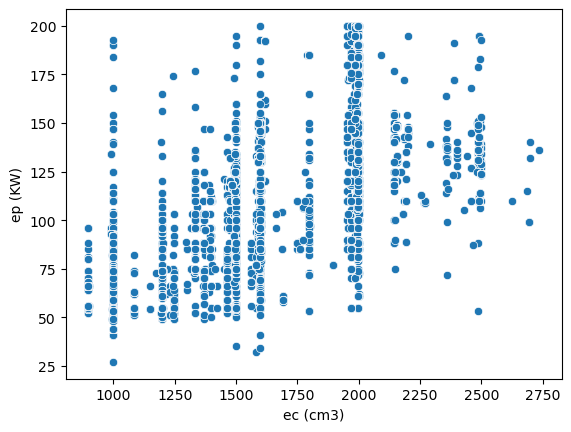

In [38]:
import seaborn as sns


sns.scatterplot(x = "ec (cm3)", y = "ep (KW)", data = df)

C:\Users\onepl\AppData\Local\Temp\ipykernel_17504\102121001.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


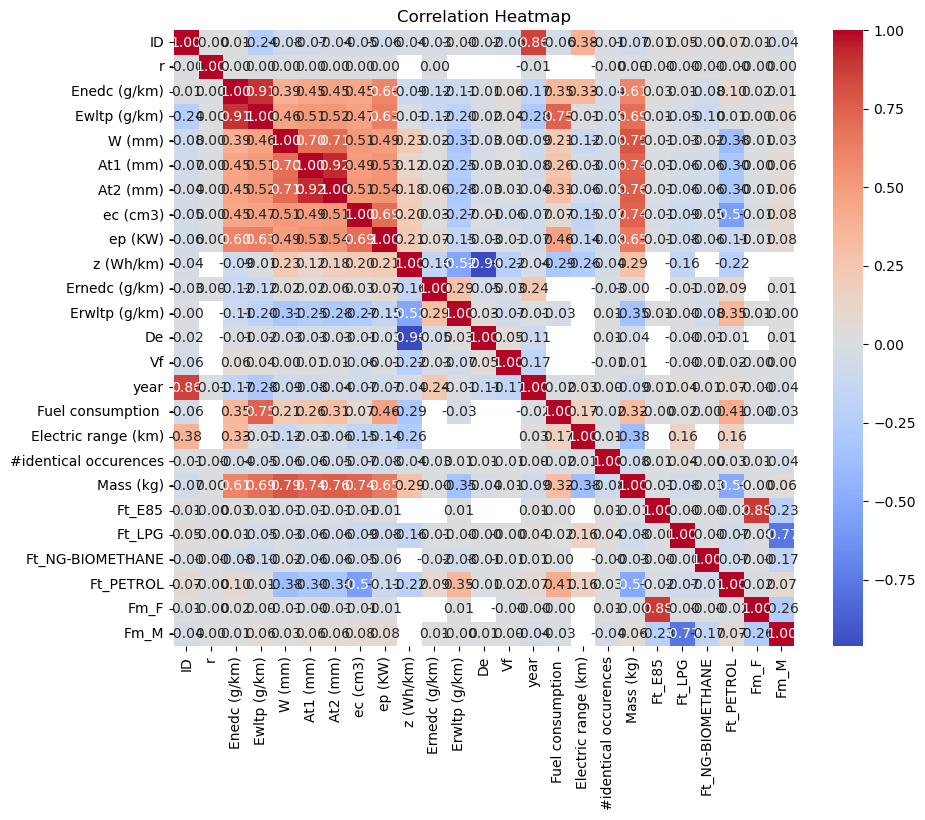

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Add intercept for VIF calculation
X_train_sm = sm.add_constant(X_train_scaled)

vif_data = pd.DataFrame()
vif_data['Feature'] = ['Intercept'] + list(X_train.columns)
vif_data['VIF'] = [variance_inflation_factor(X_train_sm, i) for i in range(X_train_sm.shape[1])]

print(vif_data)


             Feature       VIF
0          Intercept  1.000000
1          Mass (kg)  5.854877
2             W (mm)  2.992001
3           At1 (mm)  7.200090
4           At2 (mm)  7.559979
5           ec (cm3)  4.106737
6            ep (KW)  3.082834
7               Fm_F  4.720514
8          Ft_PETROL  2.262767
9             Ft_LPG  3.009682
10  Ft_NG-BIOMETHANE  1.124523
11              Fm_M  3.283527
12            Ft_E85  4.503919
